In [55]:
%pip install torch

Note: you may need to restart the kernel to use updated packages.


In [56]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [57]:
# ------ Question 1 ------

titanic = pd.read_csv('/Users/giovannimaya/Downloads/TitanicSurvival.csv')
titanic.head()

,rownames,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
1,"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
2,"Allison, Miss. Helen Loraine",no,female,2.0000,1st
3,"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
4,"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


In [58]:
titanic.isnull().sum()

rownames            0
survived            0
sex                 0
age               263
passengerClass      0
dtype: int64

In [59]:
from sklearn.preprocessing import LabelEncoder
titanic['age'].fillna(titanic['age'].mean(), inplace=True)

sex_encoder = LabelEncoder()
survived_encoder = LabelEncoder()
passenger_encoder = LabelEncoder()
titanic['sex'] = sex_encoder.fit_transform(titanic['sex'])
titanic['survived'] = survived_encoder.fit_transform(titanic['survived'])
titanic['passengerClass'] = passenger_encoder.fit_transform(titanic['passengerClass'])
titanic.head()

,rownames,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",1,0,29.0000,0
1,"Allison, Master. Hudson Trevor",1,1,0.9167,0
2,"Allison, Miss. Helen Loraine",0,0,2.0000,0
3,"Allison, Mr. Hudson Joshua Crei",0,1,30.0000,0
4,"Allison, Mrs. Hudson J C (Bessi",0,0,25.0000,0


In [60]:
titanic.isnull().sum()

rownames          0
survived          0
sex               0
age               0
passengerClass    0
dtype: int64

In [61]:
predictors = ['passengerClass', 'sex', 'age']
titanic[predictors] = titanic[predictors].apply(lambda x: x - x.mean())
feats = torch.tensor(titanic[predictors].values, dtype=torch.float)
target = torch.tensor(titanic['survived'].values, dtype=torch.float)
target

tensor([1., 1., 0.,  ..., 0., 0., 0.])

In [62]:
# ----- END OF A -----

In [63]:
from torch import Tensor
def forward_pass(feats: Tensor, weights: int) -> Tensor:
    z = torch.matmul(feats, weights)
    return 1 / (1 + torch.exp(-z))

weights = torch.randn(3, 1, dtype=torch.float)
stand_input = torch.tensor([[0, 29 - titanic['age'].mean(), 0]], dtype=torch.float)
prob = forward_pass(stand_input, weights)
print(prob.item())

4.143253296007288e-09


In [64]:
def cross_entropy_loss(predict: Tensor, targets: Tensor) -> Tensor:
    epsilon = 1e-6
    return -torch.mean(targets * torch.log(predict + epsilon) + (1 - targets) * torch.log(1 - predict + epsilon))
target = torch.tensor([[1.0]])
loss = cross_entropy_loss(prob, target)
print(loss.item())


13.811375617980957


In [65]:
weights = torch.randn(3, 1, dtype=torch.float32, requires_grad=True)
stand_input = torch.tensor([[0, 29 - titanic['age'].mean(), 0]], dtype=torch.float)
probability = forward_pass(stand_input, weights)
actual_survival = torch.tensor([[1]], dtype=torch.float32)
loss = cross_entropy_loss(probability, actual_survival)
loss.backward()
print("Gradients of the weights:", weights.grad)

Gradients of the weights: tensor([[ 0.0000e+00],
        [-1.0209e-09],
        [ 0.0000e+00]])


In [81]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch import optim, Tensor


def train_model(X: Tensor, y: Tensor, learning_rates, epochs=1000):
    metrics = {}
    
    for lr in learning_rates:
        weights = torch.randn(3, 1, dtype=torch.float32, requires_grad=True)
        optimizer = optim.SGD([weights], lr=lr)
        
        loss_history = []
        gradient_history = []
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            predictions = forward_pass(X, weights)
            loss = cross_entropy_loss(predictions, y)
            loss.backward()
            optimizer.step()
            
            loss_history.append(loss.item())
            gradient_history.append(weights.grad.norm().item())

        final_predictions = forward_pass(X, weights)
        predicted_classes = torch.round(final_predictions).detach()
        metrics[lr] = (loss_history, gradient_history)
        print(y.shape, predicted_classes.shape)
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(y.reshape(-1, 1).detach().numpy(), predicted_classes.numpy())
        print(conf_matrix)
        print(f"Training completed for learning rate: {lr}")
    
    return weights, metrics

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
print(target.shape)
final_weights, training_metrics = train_model(feats, target, learning_rates)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
for lr, (losses, gradients) in training_metrics.items():
    ax[0].plot(losses, label=f"LR={lr}")
    ax[1].plot(gradients, label=f"LR={lr}")

ax[0].set_title('Loss vs Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Gradient Norm vs Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Gradient Norm')
ax[1].legend()

plt.tight_layout()
plt.show()


(20052,)


TypeError: matmul(): argument 'input' (position 1) must be Tensor, not DataFrame

In [ ]:
# ----- END OF QUESTION 1 -----

In [ ]:
# ---- START OF Question 2 ----

In [78]:
recipes = pd.read_csv('/Users/giovannimaya/Downloads/epi_r-1 (1).csv')
target = recipes['cake']
feats = recipes.drop(columns=['cake'])
numeric_cols = feats.select_dtypes(include=['number']).columns
medians = feats[numeric_cols].median()
titles = feats['title']
feats = feats[numeric_cols].fillna(medians)

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(feats)

# Convert DataFrame to tensor
tensor_data = torch.tensor(numeric_data_scaled, dtype=torch.float)

tensor_data

tensor([[-9.0578e-01, -1.4580e-02, -1.4927e-02,  ..., -3.7394e-02,
         -3.0797e-02,  6.5554e+00],
        [ 4.9264e-01, -1.4652e-02, -1.8437e-02,  ..., -3.7394e-02,
         -3.0797e-02, -1.5255e-01],
        [ 2.6501e-02, -1.5396e-02, -2.1947e-02,  ..., -3.7394e-02,
         -3.0797e-02, -1.5255e-01],
        ...,
        [ 4.9264e-01, -1.4152e-02, -1.4635e-02,  ..., -3.7394e-02,
         -3.0797e-02,  6.5554e+00],
        [ 4.9264e-01, -1.3940e-02, -1.0540e-02,  ..., -3.7394e-02,
         -3.0797e-02, -1.5255e-01],
        [ 4.9264e-01, -1.4162e-02, -2.3494e-03,  ..., -3.7394e-02,
         -3.0797e-02, -1.5255e-01]])

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(nn.Module):
    def __init__(self, input_size, encoding_dim=10):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),  # First hidden layer
            nn.ReLU(True),
            nn.Linear(128, 64),          # Second hidden layer
            nn.ReLU(True),
            nn.Linear(64, encoding_dim)  # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_size),  # Reconstruction of input
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Number of features in your dataset
input_size = feats.shape[1]

# Create the AutoEncoder
autoencoder = AutoEncoder(input_size=input_size)

# MSE Loss Function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


Epoch [10/100], Loss: 0.6995
Epoch [20/100], Loss: 1.0218
Epoch [30/100], Loss: 0.9614
Epoch [40/100], Loss: 0.5884
Epoch [50/100], Loss: 0.7145
Epoch [60/100], Loss: 1.0024
Epoch [70/100], Loss: 0.5081
Epoch [80/100], Loss: 0.8206
Epoch [90/100], Loss: 0.4968
Epoch [100/100], Loss: 1.1724


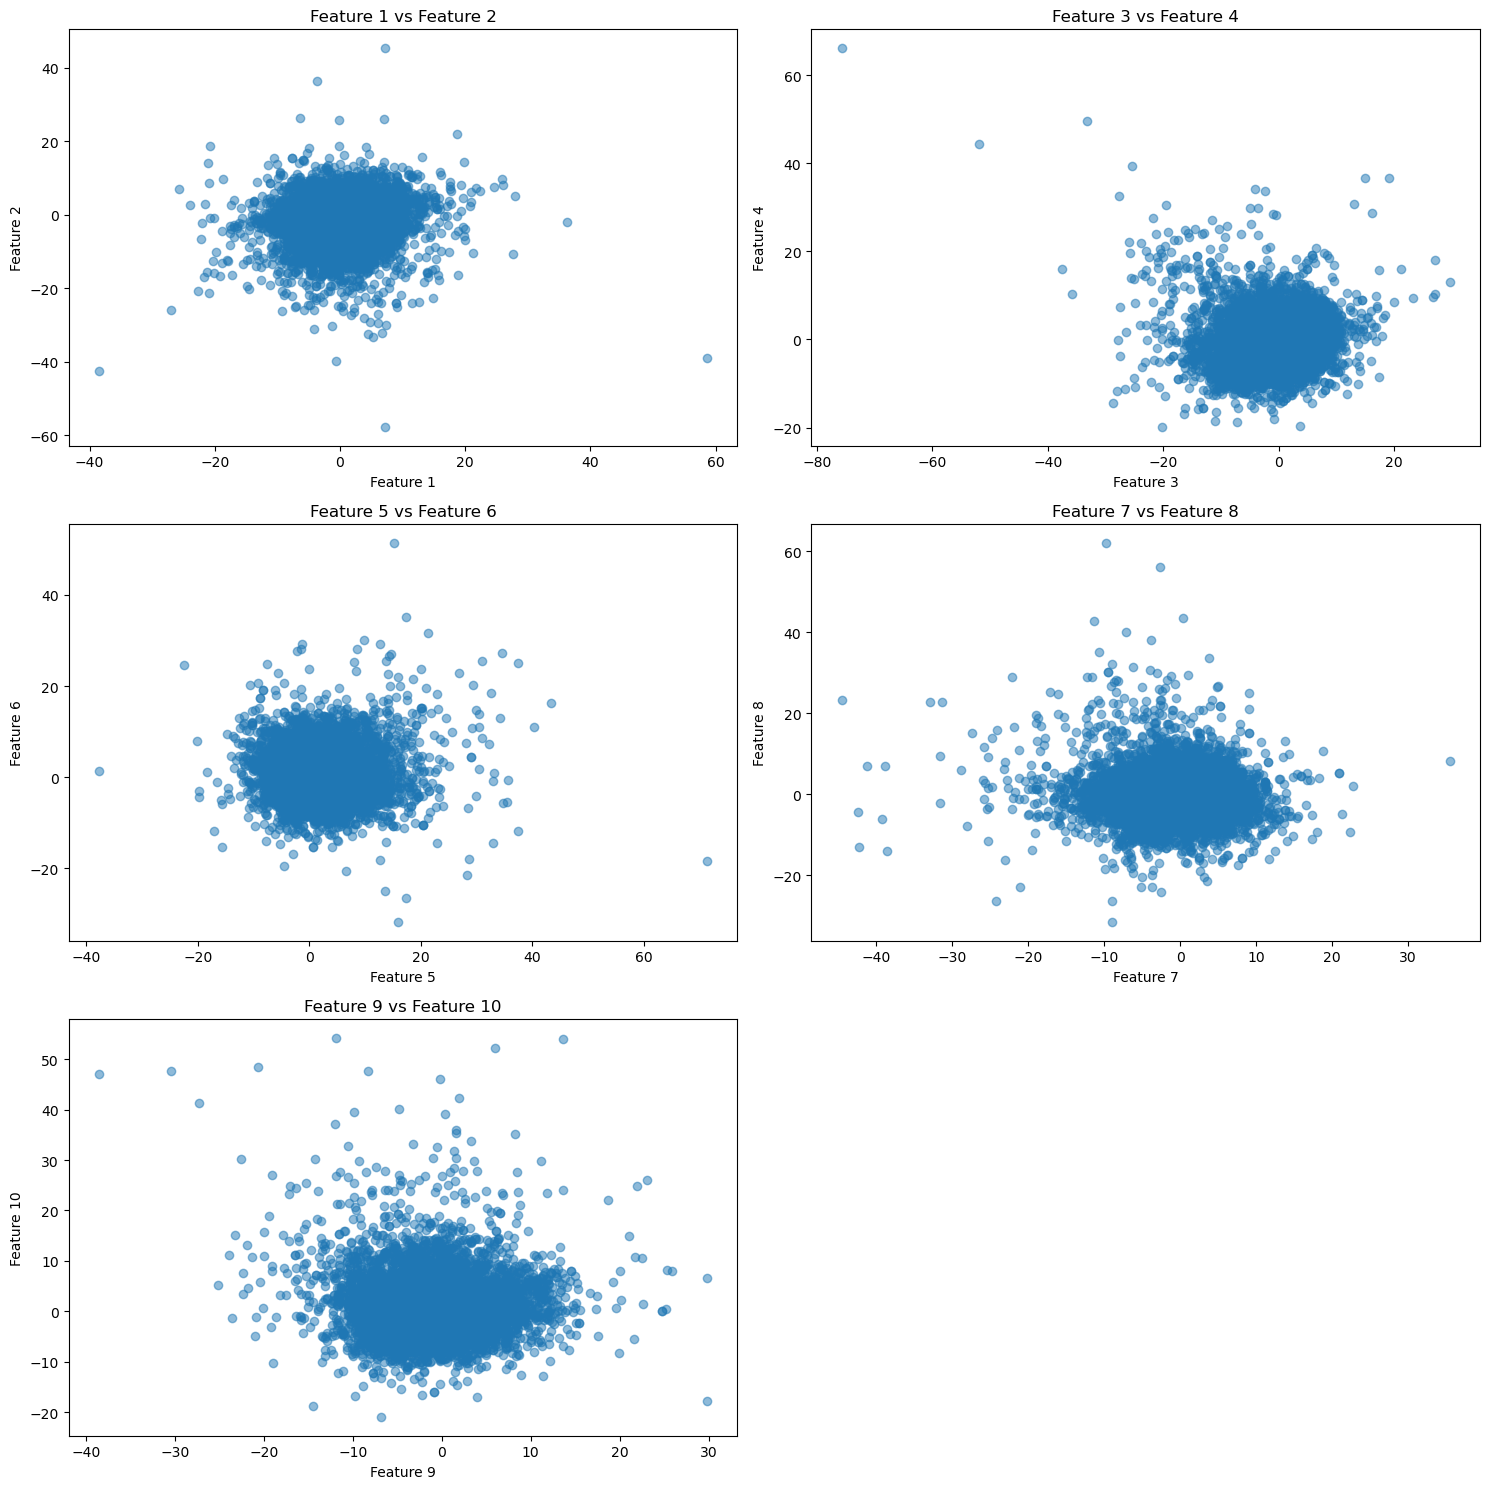

In [75]:
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=30, shuffle=True)

num_epochs = 100 

for epoch in range(num_epochs):
    for data in dataloader:

        input = data[0] 
        output = autoencoder(input)
        loss = criterion(output, input)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

encoded_samples = []
for data in dataloader:
    input = data[0]
    encoded = autoencoder.encoder(input)
    encoded_samples.append(encoded.detach())

encoded_samples = torch.cat(encoded_samples, dim=0)

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()  
for i in range(5):
    ax = axes[i]
    x_idx = 2 * i
    y_idx = 2 * i + 1
    ax.scatter(encoded_samples[:, x_idx], encoded_samples[:, y_idx], alpha=0.5)
    ax.set_xlabel(f'Feature {x_idx+1}')
    ax.set_ylabel(f'Feature {y_idx+1}')
    ax.set_title(f'Feature {x_idx+1} vs Feature {y_idx+1}')
for j in range(5, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [82]:
### --- QUESTION 1 ----

In [99]:
titanic = pd.read_csv('/Users/giovannimaya/Downloads/TitanicSurvival.csv')
titanic.head()

,rownames,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
1,"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
2,"Allison, Miss. Helen Loraine",no,female,2.0000,1st
3,"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
4,"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


In [100]:
titanic['age'].fillna(titanic['age'].mean(), inplace=True)
sex_encoder = LabelEncoder()
survived_encoder = LabelEncoder()
passenger_encoder = LabelEncoder()
titanic['survived'] = survived_encoder.fit_transform(titanic['survived'])
titanic['passengerClass'] = passenger_encoder.fit_transform(titanic['passengerClass'])
titanic['sex'] = sex_encoder.fit_transform(titanic['sex'])
titanic.head()

,rownames,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",1,0,29.0000,0
1,"Allison, Master. Hudson Trevor",1,1,0.9167,0
2,"Allison, Miss. Helen Loraine",0,0,2.0000,0
3,"Allison, Mr. Hudson Joshua Crei",0,1,30.0000,0
4,"Allison, Mrs. Hudson J C (Bessi",0,0,25.0000,0


In [101]:
## centering for q1 part A

predictors = ['sex', 'age', 'passengerClass']
titanic[predictors] = titanic[predictors].apply(lambda x: x - x.mean())
feats = torch.tensor(titanic[predictors].values, dtype=torch.float)
target = torch.tensor(titanic['survived'].values, dtype=torch.float)
target.shape, feats.shape

## end of part a 

(torch.Size([1309]), torch.Size([1309, 3]))

In [92]:
## start of part b 


In [142]:
def forward_pass(feats: Tensor, weights: int) -> Tensor:
    z = torch.matmul(feats, weights)
    return 1 / (1 + torch.exp(-z))

weights = torch.randn(3, 1, dtype=torch.float, requires_grad=True)
print(titanic.iloc[0][predictors])
stand_input = torch.tensor(titanic.iloc[0][predictors], dtype=torch.float)
prob = forward_pass(stand_input, weights)
print(prob.item())

sex              -0.644003
age              -0.881135
passengerClass   -1.294882
Name: 0, dtype: object
0.593690812587738


/var/folders/c1/5zzf4b396wdgc4t2xxg1dqw00000gn/T/ipykernel_80954/2474114753.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stand_input = torch.tensor(titanic.iloc[0][predictors], dtype=torch.float)


In [143]:
def cross_entropy_loss(predict: Tensor, targets: Tensor) -> Tensor:
    epsilon = 1e-6
    return -torch.mean(targets * torch.log(predict + epsilon) + (1 - targets) * torch.log(1 - predict + epsilon))
target = torch.tensor([[1.0]])
loss = cross_entropy_loss(prob, target)
print(loss.item())

0.5213949084281921


In [144]:
loss.backward()
print("Gradients of the weights:", weights.grad)

Gradients of the weights: tensor([[0.2617],
        [0.3580],
        [0.5261]])


In [135]:
## end of c both parts 

torch.Size([1309]) torch.Size([1309, 1])
[[669 140]
 [161 339]]
Training completed for learning rate: 0.01
torch.Size([1309]) torch.Size([1309, 1])
[[236 573]
 [409  91]]
Training completed for learning rate: 0.001
torch.Size([1309]) torch.Size([1309, 1])
[[612 197]
 [160 340]]
Training completed for learning rate: 0.0001
torch.Size([1309]) torch.Size([1309, 1])
[[505 304]
 [290 210]]
Training completed for learning rate: 1e-05
torch.Size([1309]) torch.Size([1309, 1])
[[504 305]
 [283 217]]
Training completed for learning rate: 1e-06


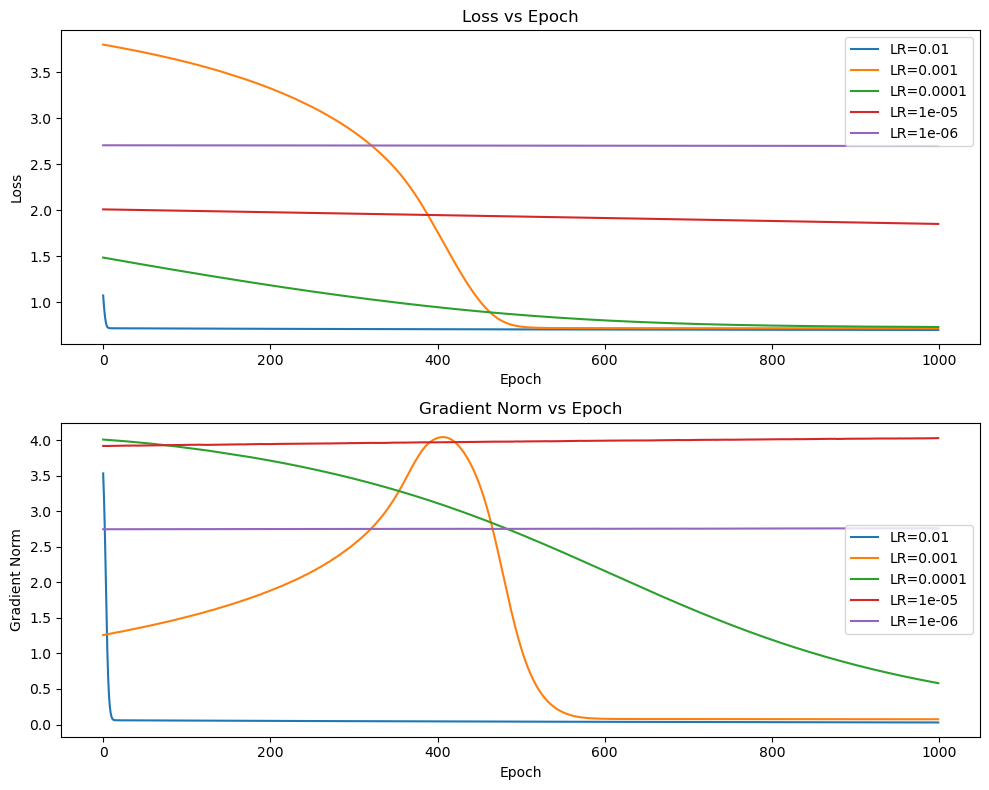

In [146]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch import optim, Tensor


def train_model(X: Tensor, y: Tensor, learning_rates, epochs=1000):
    metrics = {}
    
    for lr in learning_rates:
        weights = torch.randn(3, 1, dtype=torch.float, requires_grad=True)
        optimizer = optim.SGD([weights], lr=lr)
        
        loss_history = []
        gradient_history = []
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            predictions = forward_pass(X, weights)
            loss = cross_entropy_loss(predictions, y)
            loss.backward()
            optimizer.step()
            
            loss_history.append(loss.item())
            gradient_history.append(weights.grad.norm().item())

        final_predictions = forward_pass(X, weights)
        predicted_classes = torch.round(final_predictions).detach()
        metrics[lr] = (loss_history, gradient_history)
        print(y.shape, predicted_classes.shape)
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(y.reshape(-1, 1).detach().numpy(), predicted_classes.numpy())
        print(conf_matrix)
        print(f"Training completed for learning rate: {lr}")
    
    return weights, metrics
target = torch.tensor(titanic['survived'].values, dtype=torch.float)
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
final_weights, training_metrics = train_model(feats, target, learning_rates)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
for lr, (losses, gradients) in training_metrics.items():
    ax[0].plot(losses, label=f"LR={lr}")
    ax[1].plot(gradients, label=f"LR={lr}")

ax[0].set_title('Loss vs Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].set_title('Gradient Norm vs Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Gradient Norm')
ax[1].legend()

plt.tight_layout()
plt.show()


In [147]:
## ---- END of Q1 ----

In [159]:
from sklearn.preprocessing import StandardScaler
recipes = pd.read_csv('/Users/giovannimaya/Downloads/epi_r-1 (1).csv')
target = recipes['cake']
feats = recipes.drop(columns=['cake'])
numeric_cols = feats.select_dtypes(include=['number']).columns
medians = feats[numeric_cols].median()
titles = feats['title']
feats = feats[numeric_cols].fillna(medians)
scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(feats)
tensor_data = torch.tensor(numeric_data_scaled, dtype=torch.float)
target_data = torch.tensor(target.values, dtype=torch.float)
tensor_data, target_data

(tensor([[-9.0578e-01, -1.4580e-02, -1.4927e-02,  ..., -3.7394e-02,
          -3.0797e-02,  6.5554e+00],
         [ 4.9264e-01, -1.4652e-02, -1.8437e-02,  ..., -3.7394e-02,
          -3.0797e-02, -1.5255e-01],
         [ 2.6501e-02, -1.5396e-02, -2.1947e-02,  ..., -3.7394e-02,
          -3.0797e-02, -1.5255e-01],
         ...,
         [ 4.9264e-01, -1.4152e-02, -1.4635e-02,  ..., -3.7394e-02,
          -3.0797e-02,  6.5554e+00],
         [ 4.9264e-01, -1.3940e-02, -1.0540e-02,  ..., -3.7394e-02,
          -3.0797e-02, -1.5255e-01],
         [ 4.9264e-01, -1.4162e-02, -2.3494e-03,  ..., -3.7394e-02,
          -3.0797e-02, -1.5255e-01]]),
 tensor([0., 0., 0.,  ..., 0., 0., 0.]))

In [160]:
import torch
import torch.nn as nn
import torch.optim as optim

class AutoEncoder(nn.Module):
    def __init__(self, input_size, encoding_dim=10):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),  # First hidden layer
            nn.ReLU(True),
            nn.Linear(128, 64),          # Second hidden layer
            nn.ReLU(True),
            nn.Linear(64, encoding_dim)  # Compressed representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, input_size),  # Reconstruction of input
            nn.Tanh()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded 

In [161]:
input_size = feats.shape[1]
model = AutoEncoder(input_size=input_size)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [167]:
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

dataset = TensorDataset(tensor_data, target_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

num_epochs = 100 

for epoch in range(num_epochs):
    for data in dataloader:
        inputs = data[0]
        encoded, decoded = model(inputs) 
        loss = criterion(decoded, inputs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 1.0098
Epoch [20/100], Loss: 0.9457
Epoch [30/100], Loss: 0.9525
Epoch [40/100], Loss: 1.4216
Epoch [50/100], Loss: 0.7810
Epoch [60/100], Loss: 0.7392
Epoch [70/100], Loss: 0.6970
Epoch [80/100], Loss: 1.9061
Epoch [90/100], Loss: 0.4682
Epoch [100/100], Loss: 0.9329


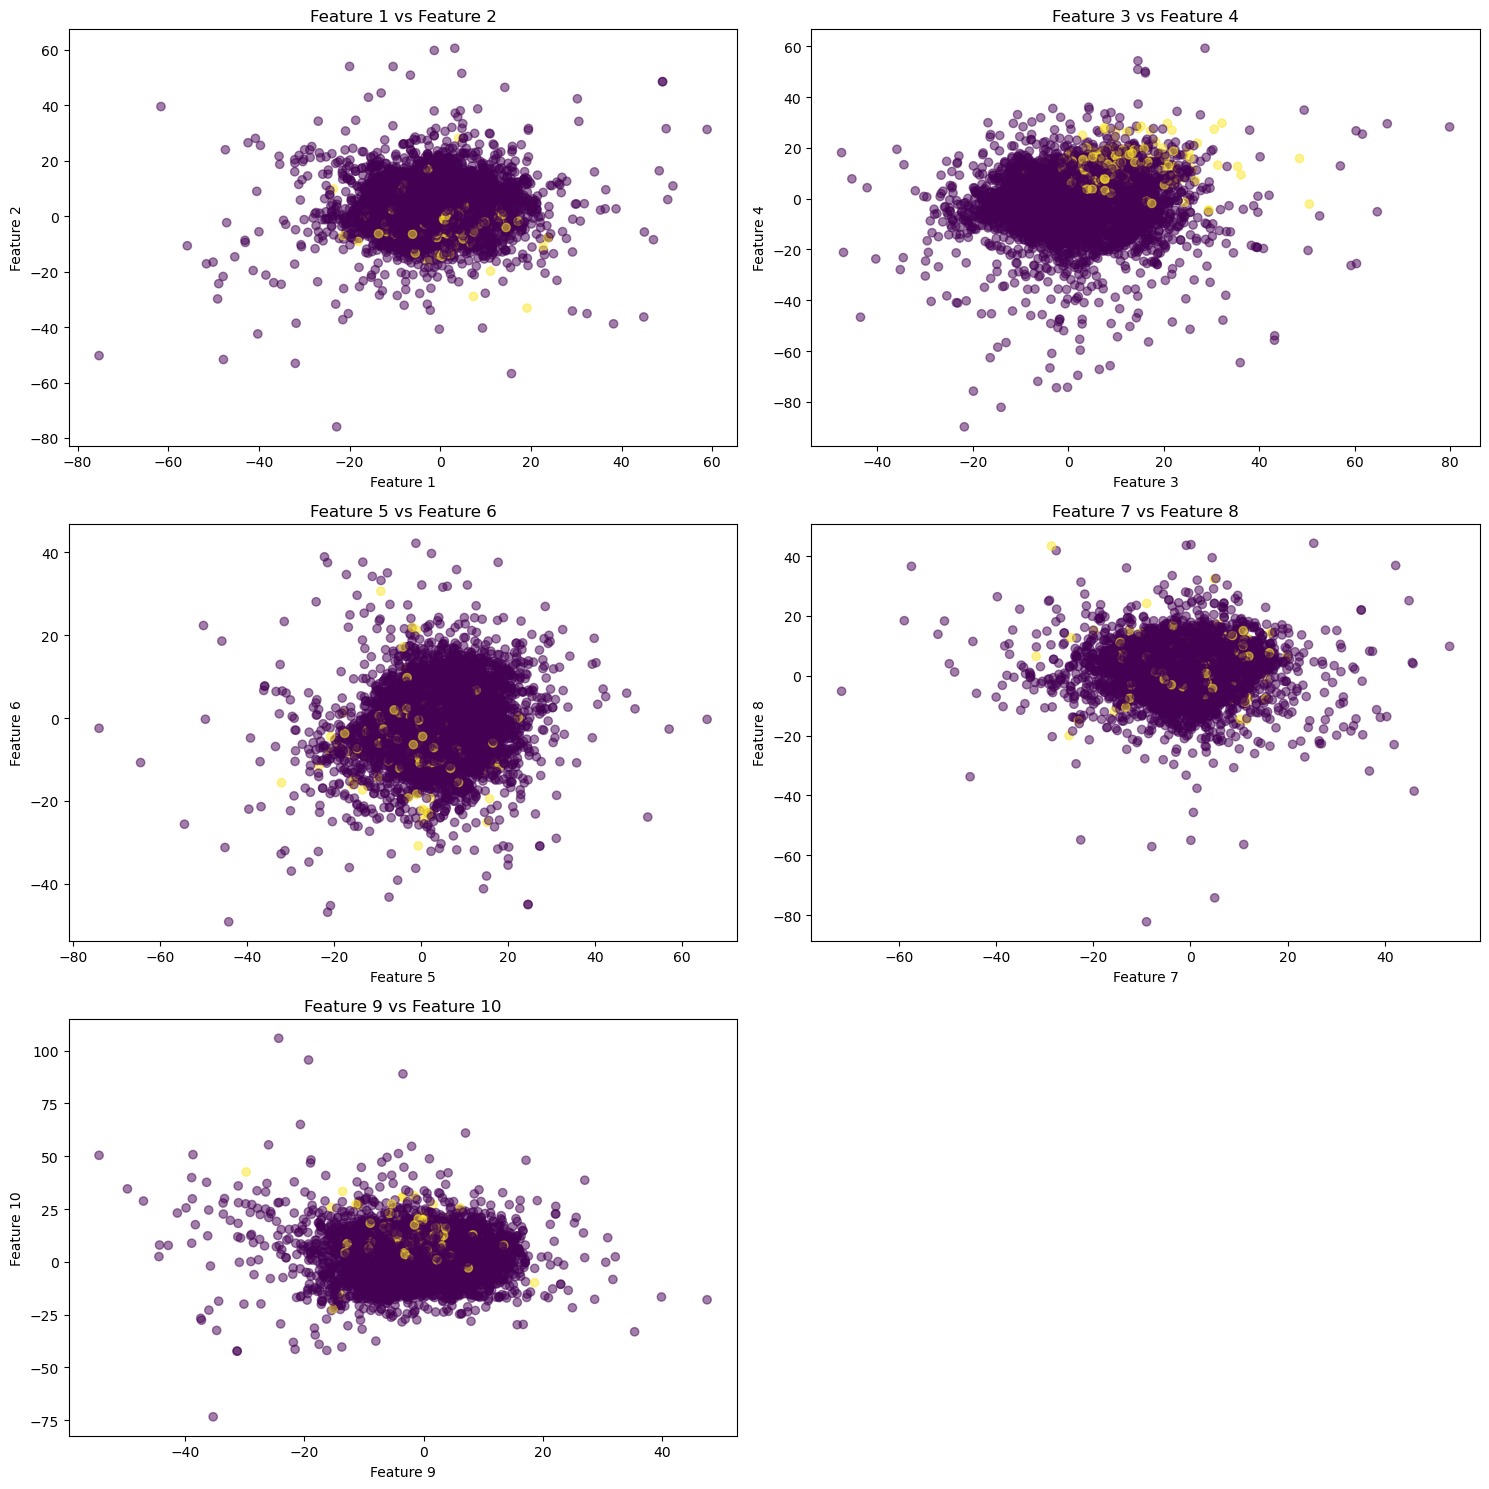

In [170]:
encoded_samples = []
labels = []
for data in dataloader:
    inputs, targets = data
    encoded, _ = model(inputs)
    encoded_samples.append(encoded.detach())
    labels.append(targets)
encoded_samples = torch.cat(encoded_samples, dim=0)
labels = torch.cat(labels, dim=0)
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()  
cmap = plt.get_cmap("viridis")
for i in range(5):
    ax = axes[i]
    x_idx = 2 * i
    y_idx = 2 * i + 1
    ax.scatter(encoded_samples[:, x_idx], encoded_samples[:, y_idx], c=labels.numpy(), alpha=0.5)
    ax.set_xlabel(f'Feature {x_idx+1}')
    ax.set_ylabel(f'Feature {y_idx+1}')
    ax.set_title(f'Feature {x_idx+1} vs Feature {y_idx+1}')
for j in range(5, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()